<a href="https://colab.research.google.com/github/galib96/protein-sequence-class-pfam/blob/main/protein_sequence_classification_with_pfam_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connecting to google drive
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, CuDNNLSTM

%matplotlib inline

In [3]:
# data_path = "/content/gdrive/MyDrive/Colab Notebooks/Protein Sequence Classification -  Pfam/DATA/pfam/random_split"
# def read_data(partition):
#     data = []
#     for fn in os.listdir(os.path.join(data_path, partition)):
#         with open(os.path.join(data_path, partition, fn)) as f:
#             data.append(pd.read_csv(f, index_col=None))
#     return pd.concat(data)
  
# # reading all data_partitions
# df_train = read_data('train')
# df_val = read_data('dev')
# df_test = read_data('test')

# df_train.head()

In [4]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Protein Sequence Classification -  Pfam/DATA/train.csv')
df_val = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Protein Sequence Classification -  Pfam/DATA/val.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Protein Sequence Classification -  Pfam/DATA/test.csv')

df_train.drop('Unnamed: 0', inplace=True, axis=1)
df_val.drop('Unnamed: 0', inplace=True, axis=1)
df_test.drop('Unnamed: 0', inplace=True, axis=1)

print("Training set size", df_train.shape)
print("Val set size", df_val.shape)
print("Test Set size", df_test.shape)

df_train.head()

Training set size (1086741, 5)
Val set size (126171, 5)
Test Set size (126171, 5)


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...
3,Transposase_20,Q981X5_RHILO/224-313,PF02371.16,VEAYQAMRGASFLVAVIFAAEI.GDV.RR.FDTPPQLMAFLGLVPG...,VEAYQAMRGASFLVAVIFAAEIGDVRRFDTPPQLMAFLGLVPGERS...
4,Mycobact_memb,MMPS4_MYCLE/16-154,PF05423.13,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


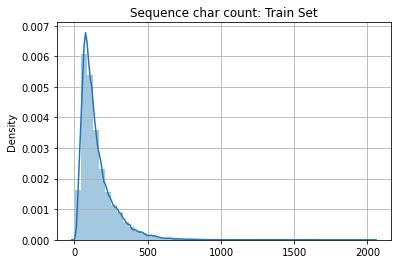

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


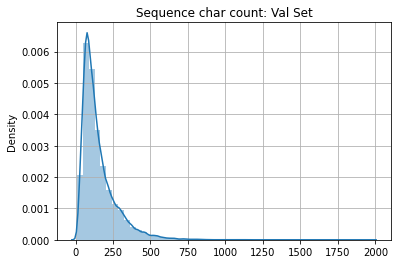

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


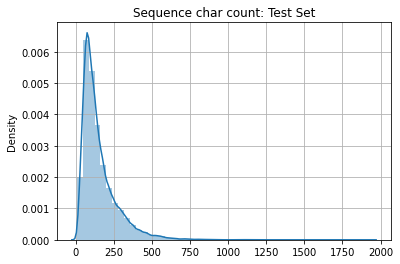

In [5]:
# finding length of the sequence

df_train['sequence_length'] = df_train['sequence'].apply(lambda x: len(x))
df_test['sequence_length'] = df_test['sequence'].apply(lambda x: len(x))
df_val['sequence_length'] = df_val['sequence'].apply(lambda x: len(x))

# plotting count by sequence lengths
def plot_seq_len(df, df_name):
    sns.distplot(df['sequence_length'].values)
    plt.title(f'Sequence char count: {df_name}')
    plt.grid(True)
    plt.show()

plot_seq_len(df_train, "Train Set")
plot_seq_len(df_val, "Val Set")
plot_seq_len(df_test, "Test Set")

In [6]:
# filtering dataset based on most 

classes = df_train['family_accession'].value_counts()[:250].index.tolist()

train_df = df_train.loc[df_train['family_accession'].isin(classes)].reset_index(drop=True)
val_df = df_val.loc[df_val['family_accession'].isin(classes)].reset_index(drop=True)
test_df = df_test.loc[df_test['family_accession'].isin(classes)].reset_index(drop=True)

print('Dataset size after taking 250 classes for each data split:')
print('Train size :', len(train_df))
print('Val size :', len(val_df))
print('Test size :', len(test_df))

Dataset size after taking 250 classes for each data split:
Train size : 184460
Val size : 22917
Test size : 22917


In [7]:
code_numeric = {' ':0, 'A':1, 'R':2, 'N':3, 'D':4, 'B':0, 'C':5, 'E':6, 'Q':7, 'Z':0, 'G':8, 'H':9, 'I':10, 'X':0, 
                 'L':11, 'K':12, 'M':13, 'F':14, 'P':15, 'S':16, 'T':17, 'W':18, 'Y':19, 'V':20, 'U':0, 'O':0}

code_numeric

{' ': 0,
 'A': 1,
 'B': 0,
 'C': 5,
 'D': 4,
 'E': 6,
 'F': 14,
 'G': 8,
 'H': 9,
 'I': 10,
 'K': 12,
 'L': 11,
 'M': 13,
 'N': 3,
 'O': 0,
 'P': 15,
 'Q': 7,
 'R': 2,
 'S': 16,
 'T': 17,
 'U': 0,
 'V': 20,
 'W': 18,
 'X': 0,
 'Y': 19,
 'Z': 0}

In [8]:
def int_encoding(sequence):
    encode = []
    for code in sequence:
        encode.append(code_numeric.get(code, 0))
  
    return np.array(encode)

# test case
int_encoding('QWERTYUIOPLKJHGFDSAZXCVBNM QWEEWQLKFA MDSNMZLPOTIGRT')

array([ 7, 18,  6,  2, 17, 19,  0, 10,  0, 15, 11, 12,  0,  9,  8, 14,  4,
       16,  1,  0,  0,  5, 20,  0,  3, 13,  0,  7, 18,  6,  6, 18,  7, 11,
       12, 14,  1,  0, 13,  4, 16,  3, 13,  0, 11, 15,  0, 17, 10,  8,  2,
       17])

In [9]:
train_df['encoded'] = train_df['sequence'].apply(int_encoding)
val_df['encoded'] = val_df['sequence'].apply(int_encoding)
test_df['encoded'] = test_df['sequence'].apply(int_encoding)

train_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length,encoded
0,TatC,G2KP71_MICAA/17-235,PF00902.18,DHLVELRTRLL.W..CFVAILAGTVFC.........Y..V.F.......,DHLVELRTRLLWCFVAILAGTVFCYVFVQDIYGFLVRPLADAMGPG...,219,"[4, 9, 11, 20, 6, 11, 2, 17, 2, 11, 11, 18, 5,..."
1,GTP1_OBG,R6UFI3_9STAP/3-157,PF01018.22,VDSVKIHVKAGNGGNG.GS..YFLHEKYVAMGG..PS...GGNGGR...,VDSVKIHVKAGNGGNGGSYFLHEKYVAMGGPSGGNGGRGGSVIFVG...,155,"[20, 4, 16, 20, 12, 10, 9, 20, 12, 1, 8, 3, 8,..."
2,YgbB,K7RUM2_ACIA4/10-161,PF02542.16,.RTGIGTDVHQL............R....P...................,RTGIGTDVHQLRPGVPMHVAGLHFPDEAEGLAGHSDGDVAAHAICD...,152,"[2, 17, 8, 10, 8, 17, 4, 20, 9, 7, 11, 2, 15, ..."
3,NAD_Gly3P_dh_C,V5WDP6_9SPIO/186-338,PF07479.14,DVVGVQVSAAL..KNVIAIAFGILDAL.K..EYS......GSVGD....,DVVGVQVSAALKNVIAIAFGILDALKEYSGSVGDNTESLLLAGGLN...,153,"[4, 20, 20, 8, 20, 7, 20, 16, 1, 1, 11, 12, 3,..."
4,P5CR_dimer,P5CR_STAEQ/161-265,PF14748.6,EEHLHQVTAITGSGPA.FLYHVFEQYVKAGTE....L..GLERNQV...,EEHLHQVTAITGSGPAFLYHVFEQYVKAGTELGLERNQVEESIRNL...,105,"[6, 6, 9, 11, 9, 7, 20, 17, 1, 10, 17, 8, 16, ..."


In [10]:
train_encode = train_df['encoded'].to_list()
val_encode = val_df['encoded'].to_list()
test_encode = test_df['encoded'].to_list()

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

print(train_pad.shape, val_pad.shape, test_pad.shape)

(184460, 100) (22917, 100) (22917, 100)


In [11]:
train_one = to_categorical(train_pad)
val_one = to_categorical(val_pad)
test_one = to_categorical(test_pad)

print(train_one.shape, val_one.shape, test_one.shape) 

(184460, 100, 21) (22917, 100, 21) (22917, 100, 21)


In [12]:
le = LabelEncoder()

y_train_le = le.fit_transform(train_df['family_accession'])
y_val_le = le.transform(val_df['family_accession'])
y_test_le = le.transform(test_df['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((184460,), (22917,), (22917,))

In [13]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((184460, 250), (22917, 250), (22917, 250))

Bi Directional LSTM

In [19]:
tf.keras.backend.clear_session()

x_input = Input(shape=(100,))

emb = Embedding(21, 128, input_length=100)(x_input)

bi_rnn = Bidirectional(CuDNNLSTM(64, 
                                kernel_regularizer=l2(0.01), 
                                recurrent_regularizer=l2(0.01), 
                                bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.2)(bi_rnn)

# softmax classifier
x_output = Dense(250, activation='softmax')(x)

model1 = keras.Sequential()
model1.add(
    keras.Input(shape=(100,))

)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer=Adam(learning_rate=0.01,decay=5e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          2688      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               99328     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               32250     
Total params: 134,266
Trainable params: 134,266
Non-trainable params: 0
_________________________________________________________________


In [20]:
# early stopping callback if model doesn't improvee
early_cb = tf.keras.callbacks.EarlyStopping(
    patience=5, verbose=1, monitor='val_loss', restore_best_weights=True, mode='min'
)

# reduce learning rate if model performance doesn't improve
lr_call = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min'
    )

# save the best model for later use
checkpoint_path = 'cp.ckpt'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# model training
history1 = model1.fit(
        train_pad, y_train,
        epochs=30, batch_size=512,
        validation_data=(val_pad, y_val),
        callbacks=[early_cb, lr_call, checkpoint_cb]
    )

Epoch 1/30
361/361 [==============================] - 43s 112ms/step - loss: 2.9187 - accuracy: 0.4885 - val_loss: 1.2032 - val_accuracy: 0.8260

Epoch 00001: val_loss improved from inf to 1.20324, saving model to cp.ckpt
Epoch 2/30
361/361 [==============================] - 39s 109ms/step - loss: 1.1187 - accuracy: 0.8392 - val_loss: 0.8045 - val_accuracy: 0.9008

Epoch 00002: val_loss improved from 1.20324 to 0.80454, saving model to cp.ckpt
Epoch 3/30
361/361 [==============================] - 39s 107ms/step - loss: 0.7826 - accuracy: 0.8905 - val_loss: 0.6158 - val_accuracy: 0.9340

Epoch 00003: val_loss improved from 0.80454 to 0.61583, saving model to cp.ckpt
Epoch 4/30
361/361 [==============================] - 38s 106ms/step - loss: 0.6636 - accuracy: 0.9095 - val_loss: 0.5250 - val_accuracy: 0.9448

Epoch 00004: val_loss improved from 0.61583 to 0.52502, saving model to cp.ckpt
Epoch 5/30
361/361 [==============================] - 38s 106ms/step - loss: 0.6310 - accuracy: 0.91

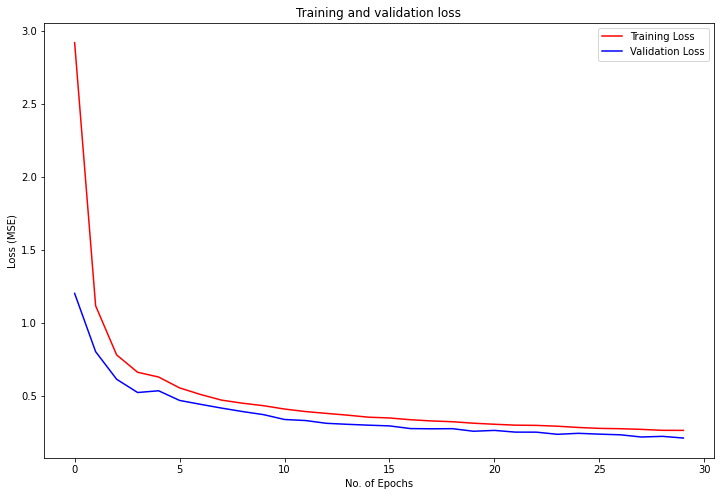

In [21]:
# result of the model training

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.show()

In [22]:
def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*25)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*25)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [23]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

721/721 [==============================] - 25s 35ms/step - loss: 0.2008 - accuracy: 0.9842
Train loss:  0.20084795355796814
Train accuracy:  0.9842079877853394
-------------------------
90/90 [==============================] - 3s 35ms/step - loss: 0.2136 - accuracy: 0.9804
Val loss:  0.21358764171600342
Val accuracy:  0.9804075360298157
-------------------------
90/90 [==============================] - 3s 35ms/step - loss: 0.2156 - accuracy: 0.9797
Test loss:  0.2155633568763733
Test accuracy:  0.9797093868255615
